Analyzing ADWIN Data

In [50]:
import random
from river import drift
import matplotlib.pyplot as plt

In [55]:
rng = random.Random()
adwin = drift.ADWIN(delta = .05,
                    clock=1,
                    min_window_length=5,
                    grace_period=1000)

data_stream = rng.choices([0, 1], k=15) + rng.choices(range(4, 8), k=15)



In [56]:
for i, val in enumerate(data_stream):
    adwin.update(val)
    if adwin.drift_detected:
        print(f"Change detected at index {i}, input value: {val}")
        print(adwin.n_detections)
print(adwin.estimation)
print(adwin.variance)

3.033333333333333
202.9666666666667


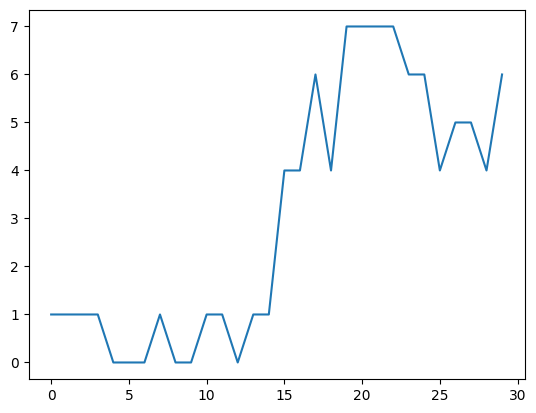

In [57]:
plt.plot(data_stream)
plt.show()